# County-Level COVID-19 Analysis

## Curtis Peterson

<font size="4">This notebook contains analysis of COVID-19 data at the county level (United States), with an emphasis on measuring how case and death rates change with vaccination rate. County-level data is interesting to me because it has sufficient granularity to capture vast differences in vaccination, infection, and death rates within a single state. I am not trained in medicine or epidemiology, and nothing presented here should be used to inform any personal or public health decisions.

County-level COVID-19 and vaccination data was downloaded using the [Covid Act Now API](https://covidactnow.org/data-api), and up-to-date county-level population data (2020 census) was downloaded at the state level from [Redistricting Data Hub](https://redistrictingdatahub.org/data/download-data/). The data from these two sources was consolidated into a simplified .csv file in a seperate notebook.
</font>

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, QuantileRegressor #Quantile Regressor requires sklearn version 1.0 or higher

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
covid_df = pd.read_csv('covid_data_withpop.csv')
covid_df.tail()

,date,country,state,county,locationId,new_cases,new_deaths,total_cases,total_deaths,icu_beds_used_covid,icu_beds_used_total,icu_beds_total,vax_initiated,vax_completed,county_pop,land_area
2089450,2021-12-25,US,WY,Weston County,iso1:us#iso2:us-wy#fips:56045,0.0,0.0,1246.0,14.0,NaN,NaN,NaN,2663.0,2368.0,6838.0,6.210804e+09
2089451,2021-12-26,US,WY,Weston County,iso1:us#iso2:us-wy#fips:56045,0.0,0.0,1246.0,14.0,NaN,NaN,NaN,2663.0,2368.0,6838.0,6.210804e+09
2089452,2021-12-27,US,WY,Weston County,iso1:us#iso2:us-wy#fips:56045,1.0,0.0,1247.0,14.0,NaN,NaN,NaN,2663.0,2368.0,6838.0,6.210804e+09
2089453,2021-12-28,US,WY,Weston County,iso1:us#iso2:us-wy#fips:56045,2.0,0.0,1249.0,14.0,NaN,NaN,NaN,2664.0,2369.0,6838.0,6.210804e+09
2089454,2021-12-29,US,WY,Weston County,iso1:us#iso2:us-wy#fips:56045,3.0,0.0,1252.0,14.0,NaN,NaN,NaN,2669.0,2372.0,6838.0,6.210804e+09


<font size="4">
The rows in this dataframe each represent a particular day for a given county. Several fields contain null values, since not every variable is reported by every county. Note that land area is in units of $m^2$. Let's have a look at the data types and number of non-null values for each variable.
</font>

In [3]:
covid_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089455 entries, 0 to 2089454
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 2089455 non-null  object 
 1   country              2089455 non-null  object 
 2   state                2089455 non-null  object 
 3   county               2089455 non-null  object 
 4   locationId           2089455 non-null  object 
 5   new_cases            2027196 non-null  float64
 6   new_deaths           1991382 non-null  float64
 7   total_cases          2046731 non-null  float64
 8   total_deaths         2001090 non-null  float64
 9   icu_beds_used_covid  97914 non-null    float64
 10  icu_beds_used_total  121475 non-null   float64
 11  icu_beds_total       134453 non-null   float64
 12  vax_initiated        1026878 non-null  float64
 13  vax_completed        1014757 non-null  float64
 14  county_pop           2039274 non-null  float64
 15

<font size="4">
I'm going to create a timestamp variable to aid with filtering by date. Note that the default unit for this timestamp is nanoseconds. Since I'm just using it for filtering purposes this is acceptable.
</font>

In [4]:
timestamps = covid_df['date'].apply(lambda x: pd.to_datetime(x).value)
timestamps.head()

0    1586390400000000000
1    1586476800000000000
2    1586563200000000000
3    1586649600000000000
4    1586736000000000000
Name: date, dtype: int64

<font size="4">
Below I will group the US states into a few regions so that data can be aggregated over multiple states. Other groupings of states are equally relevant.
<font>

In [5]:
northeast_states = ['CT', 'ME', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
midwest_states = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
southern_states = ['OK', 'TX', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'GA', 'FL', 'WV', 'DE', 'MD', 'DC', 'VA', 'NC', 'SC']
western_states = ['WA', 'OR', 'CA', 'MT', 'ID', 'NV', 'WY', 'UT', 'AZ', 'CO', 'NM']
AK = ['AK']
HI = ['HI']

all_states = northeast_states + midwest_states + southern_states + western_states + AK + HI

## Rolling Averages of Time Series

<font size="4">
The first thing I want to look at is cases vs time. I define two functions below that plot the daily cases along with a rolling average (calculated with a variable window size up to a particular day) for individual counties as well as regions (single or multiple states). This information will be used to choose date ranges in the county-level analysis I perform later.
<font>

In [6]:
def rolling_avg_county(df, timestamps, start_date, end_date, county_name, state_name, var='new_cases', window_size=14):
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    day_markers = np.arange(start_dt,end_dt,86400*10**9)
    county_filter = df['county'] == county_name
    state_filter = df['state'] == state_name
    filter_1 = county_filter & state_filter
    filtered_df = df[filter_1]
    filtered_timestamps = timestamps[filter_1]

    rolling_avg = []
    cases_by_day = []
    days = []
    for day in day_markers:
        date_filter = (filtered_timestamps > day - window_size*86400*10**9)&(filtered_timestamps <= day)
        date_filter_2 = filtered_timestamps == day
        rolling_avg.append(filtered_df[date_filter][var].sum()/window_size)
        cases_by_day.append(filtered_df[date_filter_2][var])
        days.append(pd.to_datetime(day, unit='ns'))
    
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot()
    ax.grid()
    ax.set_ylabel(var, size=30)
    plt.xticks(rotation=70)

    ax.scatter(days,cases_by_day, s=10, c='k', alpha=1.0)
    ax.plot(days,rolling_avg, linewidth=3, c='r')

    fig.suptitle(str(county_name) + ', ' + state_name + ' between ' + start_date + ' and ' + end_date, fontsize=20)

    return rolling_avg, days, fig

def rolling_avg_region(df, timestamps, start_date, end_date, state_list=[], state_list_name = '', var='new_cases', window_size=14):
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    day_markers = np.arange(start_dt,end_dt,86400*10**9)
    state_filter = df['state'].isin(state_list)
    filter_1 = state_filter
    filtered_df = df[filter_1]
    filtered_timestamps = timestamps[filter_1]

    rolling_avg = []
    cases_by_day = []
    days = []
    for day in day_markers:
        date_filter = (filtered_timestamps > day - window_size*86400*10**9)&(filtered_timestamps <= day)
        date_filter_2 = filtered_timestamps == day
        rolling_avg.append(filtered_df[date_filter][var].sum()/window_size)
        cases_by_day.append(filtered_df[date_filter_2][var].sum())
        days.append(pd.to_datetime(day, unit='ns'))

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig = plt.figure(figsize=[9,6])
    ax = fig.add_subplot()
    ax.grid()
    ax.set_ylabel(var, size=30)
    plt.xticks(rotation=70)

    ax.scatter(days,cases_by_day, s=10, c='k', alpha=1.0)
    ax.plot(days,rolling_avg, linewidth=3, c='r')

    if len(state_list) <= 3:
        fig.suptitle(str(state_list) + ' between ' + start_date + ' and ' + end_date, fontsize=20)
    else:
        fig.suptitle(state_list_name + ' between ' + start_date + ' and ' + end_date, fontsize=20)

    return rolling_avg, days, fig

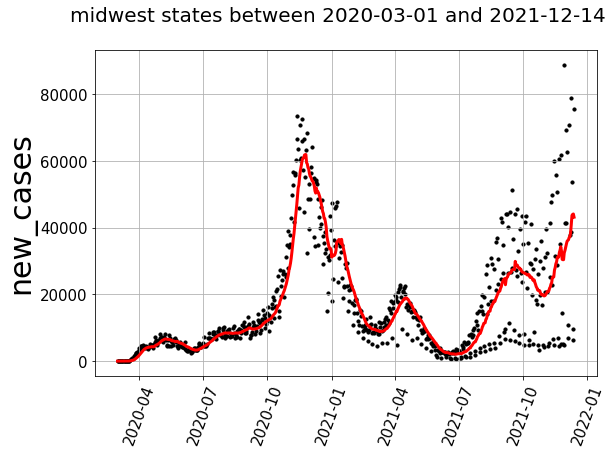

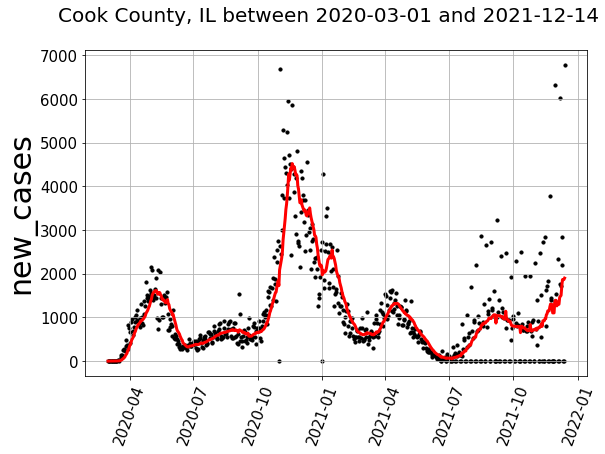

In [7]:
rolling_ave, days, fig = rolling_avg_region(covid_df,timestamps,'2020-03-01','2021-12-14', state_list=midwest_states, state_list_name='midwest states', window_size=14, var='new_cases')
rolling_ave, days, fig = rolling_avg_county(covid_df,timestamps,'2020-03-01','2021-12-14', county_name='Cook County', state_name='IL', window_size=14, var='new_cases')


<font size="4">
The first thing I want to look at is a few scatter plots of case and death rate vs vaccination rate. I am adding a county population threshold (default 50k) to filter out counties with small population because a small fluction in cases results in a relatively large fluctuation in case rate. Along with the scatter plots, I am also performing linear regression on the data to characterize any trends that are present.
<br>
<br>
The cell below contains the function I use to plot the data, along with a function that performs regression only.
<font>


In [8]:
#x_column accepts column names 'vax_initiated' and 'vax_completed'; y_column accepts column names 'new_cases' and 'new_deaths'.
def scatter_vs_vaxrate(df, timestamps, start_date, end_date, state_list=[], state_list_name = '', x_column = 'vax_initiated', y_column = 'new_cases', pop_threshold = 50000, xlims  = [30,85], ylims = [0,150]): 
    
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    date_filter = (timestamps >= start_dt)&(timestamps <= end_dt)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total = pop_filter & date_filter & state_filter
    filtered_df = df[filter_total].groupby(['state','county']).mean()

    filtered_df = filtered_df.dropna(subset=[x_column,y_column])

    xdata = filtered_df[x_column]/filtered_df['county_pop']*100
    xdata = xdata.to_numpy().reshape(-1,1)
    ydata = filtered_df[y_column]/filtered_df['county_pop']*100000
    ydata = ydata.to_numpy()

    l_reg = LinearRegression().fit(xdata,ydata)
    l_reg_pred = l_reg.predict(xdata)

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot()
    ax.set_xlim(xlims) 
    ax.set_ylim(ylims)

    ax.set_xlabel('% vaccinated')

    if y_column == 'new_cases':
        ax.set_ylabel('Average daily cases (per 100k)')
    elif y_column == 'new_deaths':
        ax.set_ylabel('Average daily deaths (per 100k)')
    
    if len(state_list) <= 3:
        fig.suptitle(str(state_list) + ' between ' + start_date + ' and ' + end_date, fontsize=20)
    else:
        fig.suptitle(state_list_name + ' between ' + start_date + ' and ' + end_date, fontsize=20)
        
    ax.scatter(xdata,ydata, s=50, c='k', alpha=0.5)
    ax.plot(xdata,l_reg_pred, c='r')

    plt.legend(['regression line: m=' + str(round(l_reg.coef_[0],3)),'counties (pop > {})'.format(pop_threshold)], fontsize=12)

    return fig, ax, l_reg

def regression_vs_vaxrate(df, timestamps, start_date,end_date,state_list=[], x_column = 'vax_initiated', y_column = 'new_cases', pop_threshold = 50000):
    
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    date_filter = (timestamps >= start_dt)&(timestamps <= end_dt)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total = pop_filter & date_filter & state_filter
    filtered_df = df[filter_total].groupby(['state','county']).mean()

    filtered_df = filtered_df.dropna(subset=[x_column,y_column])

    xdata = filtered_df[x_column]/filtered_df['county_pop']*100
    xdata = xdata.to_numpy().reshape(-1,1)
    ydata = filtered_df[y_column]/filtered_df['county_pop']*100000
    ydata = ydata.to_numpy()

    if filtered_df.shape[0] > 1:
        l_reg = LinearRegression().fit(xdata,ydata)
    else:
        dummy_x = np.arange(100)
        dummy_y = dummy_x*0
        l_reg = LinearRegression().fit(dummy_x.reshape(-1,1),dummy_y)
    return l_reg


## Analysis and Visualization for Selected States

<font size="4">
I'll start by choosing a few states to look at during times with high infection rates. Times with high infection rates were determined qualitatively using the rolling average plot function defined above. The states and time-windows chosen are:

- November 14 - December 14 in Illinois and New York.
- August 14 - October 1 in Texas
- August 1 through September 15 in California
</font>


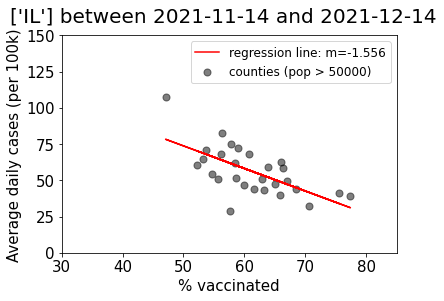

In [9]:
start_date = '2021-11-14'
end_date = '2021-12-14'

xlims = [30,85]
ylims = [0,150]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['IL'], x_column = 'vax_initiated', y_column='new_cases', xlims=xlims, ylims=ylims)


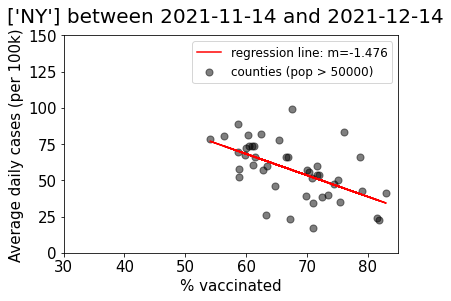

In [10]:
start_date = '2021-11-14'
end_date = '2021-12-14'

xlims = [30,85]
ylims = [0,150]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['NY'], x_column = 'vax_initiated', y_column='new_cases', xlims=xlims, ylims=ylims)

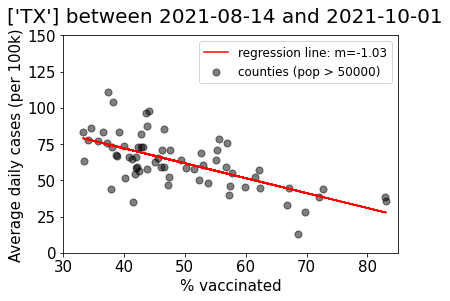

In [11]:
start_date = '2021-08-14'
end_date = '2021-10-01'

xlims = [30,85]
ylims = [0,150]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['TX'], x_column = 'vax_initiated', y_column='new_cases', xlims=xlims, ylims=ylims)

In [12]:
start_date = '2021-08-01'
end_date = '2021-09-15'

xlims = [30,85]
ylims = [0,150]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['CA'], x_column = 'vax_initiated', y_column='new_cases', xlims=xlims, ylims=ylims)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

<font size="4">
In each plot above the same trend is apparent: decreasing infection rate with increasing vaccination rate. This trend is characterized by the negative slopes of each of the regression lines. To interpret the magnitude of the slope, consider two counties with one million people and a difference in vaccination rate of 20%. In this case, a slope of -1 would correspond to a difference of 200 daily cases.
<br>
<br>
Daily cases show a clear and significant dependence on vaccination rate for the cases I have looked at so far. Next, I will repeat the same analysis for daily deaths in the same states. The time-windows chosen are:

- December 1 - December 14 in Illinois and New York.
- September 14 - October 14 in Texas
- September 1 through October 1 in California
<font>

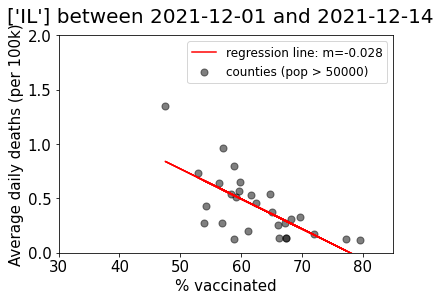

In [ ]:
start_date = '2021-12-01'
end_date = '2021-12-14'

xlims = [30,85]
ylims = [0,2]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['IL'], x_column = 'vax_initiated', y_column='new_deaths', xlims=xlims, ylims=ylims)

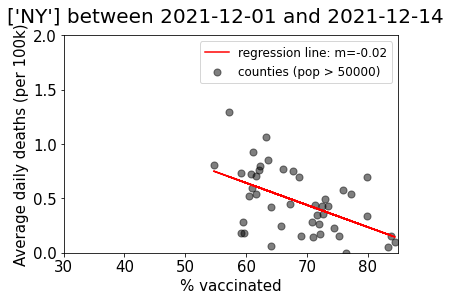

In [ ]:
start_date = '2021-12-01'
end_date = '2021-12-14'

xlims = [30,85]
ylims = [0,2]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['NY'], x_column = 'vax_initiated', y_column='new_deaths', xlims=xlims, ylims=ylims)

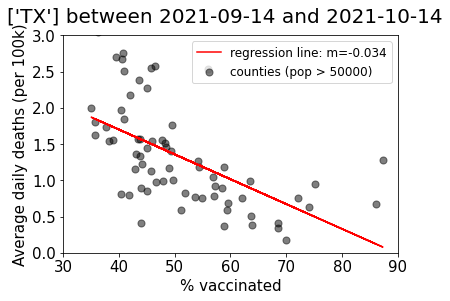

In [ ]:
start_date = '2021-09-14'
end_date = '2021-10-14'

xlims = [30,90]
ylims = [0,3]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['TX'], x_column = 'vax_initiated', y_column='new_deaths', xlims=xlims, ylims=ylims)

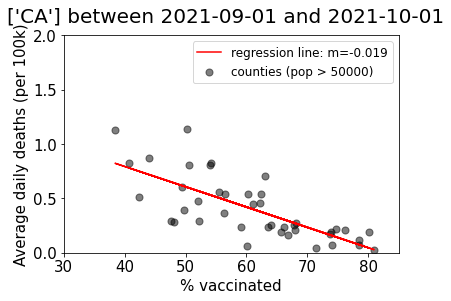

In [ ]:
start_date = '2021-09-01'
end_date = '2021-10-01'

xlims = [30,85]
ylims = [0,2]

fig, ax, l_reg = scatter_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=['CA'], x_column = 'vax_initiated', y_column='new_deaths', xlims=xlims, ylims=ylims)

<font size="4">
Similar to the trend seen with infection rates, death rates decrease with increasing vaccination rates. This trend is once again characterised using the slope of each regression line. In two counties with populations of one million people and a difference in vaccination rate of 20%, a slope of -0.02 corresponds to a difference in 4 daily deaths.


## Regression-Line Slopes by Region

<font size="4">
The plots above demonstrate that the slope of a linear regression line characterizes the relationship between COVID-19 infection rate and vaccination rate. However, only a few examples are shown above and it would be good to get some idea of how widespread this relationship is. We can efficiently describe data from a large number of states by performing linear regression on the data from each state and reporting the slopes. In the analysis below, I will construct horizontal bar charts that allow efficiently visualizing the relationship between infection rate and vaccination rate in a large number of states. The time-windows chosen for each region are:

- November 1 - December 14 in the Midwestern and Northeastern United States
- August 14 - September 14 in the Western United States
- August 14 - September 14 in the Southern United States
</font>

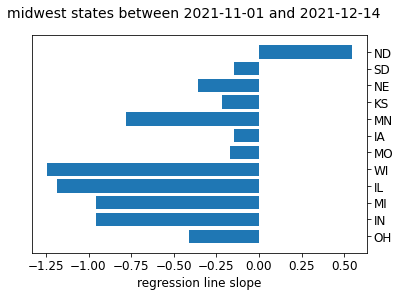

In [ ]:
start_date = '2021-11-01'
end_date = '2021-12-14'
state_list = midwest_states

reg_slopes = []
for state in state_list:
    l_reg = regression_vs_vaxrate(covid_df, timestamps, start_date, end_date, [state], x_column = 'vax_initiated', y_column='new_cases')
    reg_slopes.append(l_reg.coef_[0])

y_pos = np.arange(len(state_list))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

fig, ax = plt.subplots()
fig.suptitle('midwest states between ' + start_date + ' and ' + end_date, fontsize=14)
ax.barh(y_pos,reg_slopes)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks(y_pos)
ax.set_yticklabels(state_list)
ax.set_xlabel('regression line slope')
ax.invert_yaxis()  # labels read top-to-bottom

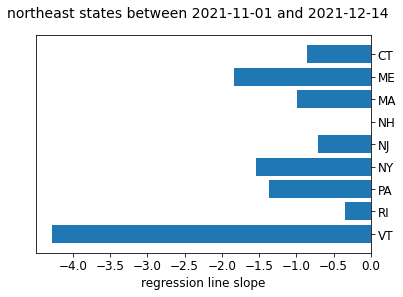

In [ ]:
start_date = '2021-11-01'
end_date = '2021-12-14'
state_list = northeast_states

reg_slopes = []
for state in state_list:
    l_reg = regression_vs_vaxrate(covid_df, timestamps, start_date, end_date, [state], x_column = 'vax_initiated', y_column='new_cases')
    reg_slopes.append(l_reg.coef_[0])

y_pos = np.arange(len(state_list))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

fig, ax = plt.subplots()
fig.suptitle('northeast states between ' + start_date + ' and ' + end_date, fontsize=14)

ax.barh(y_pos,reg_slopes)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks(y_pos)
ax.set_yticklabels(state_list)
ax.set_xlabel('regression line slope')
ax.invert_yaxis()  # labels read top-to-bottom

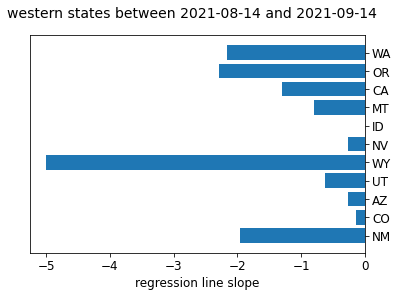

In [ ]:
start_date = '2021-08-14'
end_date = '2021-09-14'
state_list = western_states

reg_slopes = []
for state in state_list:
    l_reg = regression_vs_vaxrate(covid_df, timestamps, start_date, end_date, [state], x_column = 'vax_initiated', y_column='new_cases')
    reg_slopes.append(l_reg.coef_[0])

y_pos = np.arange(len(state_list))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

fig, ax = plt.subplots()
fig.suptitle('western states between ' + start_date + ' and ' + end_date, fontsize=14)

ax.barh(y_pos,reg_slopes)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks(y_pos)
ax.set_yticklabels(state_list)
ax.set_xlabel('regression line slope')
ax.invert_yaxis()  # labels read top-to-bottom

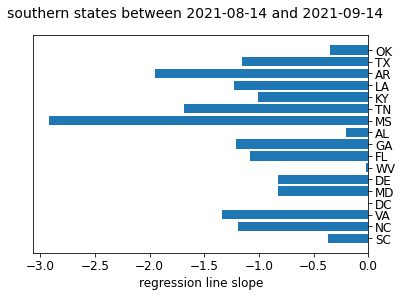

In [ ]:
start_date = '2021-08-14'
end_date = '2021-09-14'
state_list = southern_states

reg_slopes = []
for state in state_list:
    l_reg = regression_vs_vaxrate(covid_df, timestamps, start_date, end_date, [state], x_column = 'vax_initiated', y_column='new_cases')
    reg_slopes.append(l_reg.coef_[0])

y_pos = np.arange(len(state_list))

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

fig, ax = plt.subplots()
fig.suptitle('southern states between ' + start_date + ' and ' + end_date, fontsize=14)

ax.barh(y_pos,reg_slopes)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticks(y_pos)
ax.set_yticklabels(state_list)
ax.set_xlabel('regression line slope')
ax.invert_yaxis()  # labels read top-to-bottom

The analysis above show that the negative correlation between vaccination rate and COVID-19 infection rate during the second half of 2021 is practically ubiquitous.

## Quantile Regression on Nationally Aggregated Data

When considering COVID-19 infection or death rates in a large region over a particular period of time, peak rates will happen at different times and will dissipate differently within distinct parts of that large region. As a result, the distribution of the measured rates will be asymmetric. One solution to this problem is to only consider single states as in the analysis above. Alternatively, [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) can be used to obtain conditional estimates of arbitrary quantiles in the data (as opposed to a conditional estimate of the mean, as in the case of linear regression). Quantile regression was [recently implemented](https://scikit-learn.org/stable/auto_examples/linear_model/plot_quantile_regression.html) in scikit-learn (version 1.0).

In [ ]:
def quantile_reg_vs_vaxrate(df, timestamps, start_date, end_date, state_list, state_list_name = '', x_column = 'vax_initiated', y_column = 'new_cases', quantile = 0.9, pop_threshold = 50000, xlims  = [30,85], ylims = [0,150]):
    
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    date_filter = (timestamps >= start_dt)&(timestamps <= end_dt)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total = pop_filter & date_filter & state_filter
    filtered_df = df[filter_total].groupby(['state','county']).mean()

    filtered_df = filtered_df.dropna(subset=[x_column,y_column])

    xdata = filtered_df[x_column]/filtered_df['county_pop']*100
    xdata = xdata.to_numpy().reshape(-1,1)
    ydata = filtered_df[y_column]/filtered_df['county_pop']*100000
    ydata = ydata.to_numpy()

    q_reg = QuantileRegressor(quantile=quantile, alpha=0, solver='highs').fit(xdata,ydata)
    q_reg_pred = q_reg.predict(xdata)

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot()
    #ax.set_xlim(xlims) 
    #ax.set_ylim(ylims)

    ax.set_xlabel('% vaccinated')

    if y_column == 'new_cases':
        ax.set_ylabel('Average daily cases (per 100k)')
    elif y_column == 'new_deaths':
        ax.set_ylabel('Average daily deaths (per 100k)')

    
    if len(state_list) <= 3:
        fig.suptitle(str(state_list) + ' between ' + start_date + ' and ' + end_date, fontsize=20)
    else:
        fig.suptitle(state_list_name + ' between ' + start_date + ' and ' + end_date, fontsize=20)


    ax.scatter(xdata,ydata, s=50, c='k', alpha=0.5)
    ax.plot(xdata,q_reg_pred, c='r')

    plt.legend(['$Q_{{{}}}$ regression line: m='.format(str(quantile)[0:]) + str(round(q_reg.coef_[0],3)),'counties (pop > {})'.format(pop_threshold)], fontsize=12)

    return fig, ax, q_reg

def quantile_reg_vs_pop(df, timestamps, start_date, end_date, state_list, state_list_name = '', pop_density = False, y_column = 'new_cases', quantile = 0.9, pop_threshold = 50000, xlims  = [30,85], ylims = [0,150]):
    
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    date_filter = (timestamps >= start_dt)&(timestamps <= end_dt)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total = pop_filter & date_filter & state_filter
    filtered_df = df[filter_total].groupby(['state','county']).mean()

    filtered_df = filtered_df.dropna(subset=['county_pop',y_column])

    if pop_density:
        xdata = np.log10(filtered_df['county_pop']/filtered_df['land_area'])
    else:
        xdata = np.log10(filtered_df['county_pop'])
    xdata = np.array(xdata).reshape(-1,1)
    
    ydata = filtered_df[y_column]/filtered_df['county_pop']*100000
    ydata = ydata.to_numpy()

    q_reg = QuantileRegressor(quantile=quantile, alpha=0, solver='highs').fit(xdata,ydata)
    q_reg_pred = q_reg.predict(xdata)

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig = plt.figure(figsize=[6,4])
    ax = fig.add_subplot()
    #ax.set_xlim(xlims) 
    #ax.set_ylim(ylims)

    ax.set_xlabel('% vaccinated')

    if y_column == 'new_cases':
        ax.set_ylabel('Average daily cases (per 100k)')
    elif y_column == 'new_deaths':
        ax.set_ylabel('Average daily deaths (per 100k)')

    
    if len(state_list) <= 3:
        fig.suptitle(str(state_list) + ' between ' + start_date + ' and ' + end_date, fontsize=20)
    else:
        fig.suptitle(state_list_name + ' between ' + start_date + ' and ' + end_date, fontsize=20)


    ax.scatter(xdata,ydata, s=50, c='k', alpha=0.5)
    ax.plot(xdata,q_reg_pred, c='r')

    plt.legend(['$Q_{{{}}}$ regression line: m='.format(str(quantile)[0:]) + str(round(q_reg.coef_[0],3)),'counties (pop > {})'.format(pop_threshold)], fontsize=12)

    return fig, ax, q_reg

In [ ]:
def quantile_regression_vs_vaxrate(df, timestamps, start_date, end_date, state_list=[], x_column = 'vax_initiated', y_column = 'new_cases', quantile=0.9, pop_threshold = 50000):
    
    start_dt = pd.to_datetime(start_date).value
    end_dt = pd.to_datetime(end_date).value
    date_filter = (timestamps >= start_dt)&(timestamps <= end_dt)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total = pop_filter & date_filter & state_filter
    filtered_df = df[filter_total].groupby(['state','county']).mean()

    filtered_df = filtered_df.dropna(subset=[x_column,y_column])

    xdata = filtered_df[x_column]/filtered_df['county_pop']*100
    xdata = xdata.to_numpy().reshape(-1,1)
    ydata = filtered_df[y_column]/filtered_df['county_pop']*100000
    ydata = ydata.to_numpy()

    if filtered_df.shape[0] > 1:
        q_reg = QuantileRegressor(quantile=quantile, alpha=0, solver='highs').fit(xdata,ydata)
        q_reg_pred = q_reg.predict(xdata)
    else:
        dummy_x = np.arange(100)
        dummy_y = dummy_x*0
        q_reg = QuantileRegressor().fit(dummy_x.reshape(-1,1),dummy_y)
    return q_reg

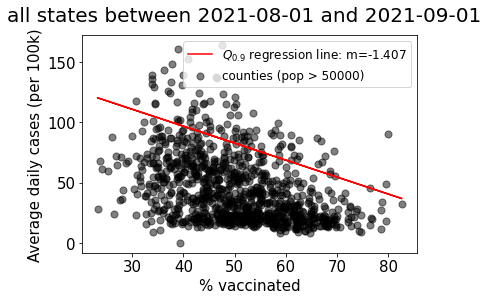

In [ ]:
start_date = '2021-08-01'
end_date = '2021-09-01'

ylims = [0,150]

fig, ax, q_reg = quantile_reg_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=all_states, state_list_name='all states', x_column = 'vax_initiated', y_column='new_cases', quantile=0.9, xlims=xlims, ylims=ylims)

Quantile regression provides a conditional estimate for an arbitrary quantile of the data as opposed to just the mean. This facilitates answering questions regaurding extremes in the data (e.g. the 10% of counties with the highest daily COVID-19 cases). The asymmetric wedge shape of the data plotted above suggests that the relationship between vaccination rate and COVID-19 infection rate changes depending on which quantile is being measured. In the analysis below, I perform quantile regression for quantiles ranging from 0.1 to 0.9 and plot the slope as a function of quantile. 

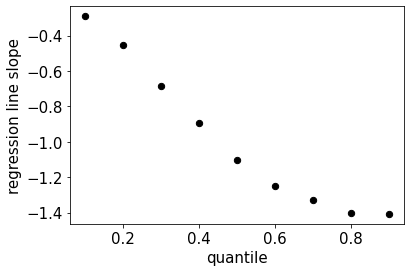

In [ ]:
start_date = '2021-08-01'
end_date = '2021-09-01'

quantiles = np.arange(0.1,1,0.1)
slopes = []
for q in quantiles:
    q_reg = quantile_regression_vs_vaxrate(covid_df, timestamps, start_date, end_date, state_list=all_states, y_column = 'new_cases', quantile = q, pop_threshold = 50000)
    slopes.append(q_reg.coef_)

plt.scatter(quantiles, slopes, c='k', s=40)
plt.xlabel('quantile')
plt.ylabel('regression line slope')
plt.show()

As one might expect from the wedge shape of the data, the slope of the quantile regression line becomes more negative as the quantile increases. This result can be interpreted as follows: in areas where COVID-19 infection rates are currently low, there is not much difference between counties with low and high vaccination rates. However, in areas where COVID-19 infections are high, counties with higher vaccination rates generally fare better.

## Pre and Post-Vaccination Comparisons

There are a number of other factors that affect the number of infections and deaths a particular area experiences. For example, population density affects the trajectory of infections in a particular area because it
[impacts the number of contacts between contageous and susceptable people.](https://www.nature.com/articles/s41591-020-1104-0) The number of previous infections in a particular area may also affect the number of current infections because some previously infected people are [not susceptible due to temporary immunity](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The two functions defined below are designed to compare average daily cases or deaths for a particular set of counties over two different time periods (i.e. before and after vaccines were available). The first creates scatter plots of COVID-19 infection or death rates vs population density for all counties in a defined region, and performs linear regression to measure the dependence. The second creates a scatter plot of COVID-19 infection or death rates for one time period vs another.
<br>
<br>
The plots below focus on the Southern United States over two time periods:

- December 1 2020 - February 1 2021
- August 1 2021 - October 1 2021

In [ ]:
def scatter_pop_comparison(df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=[], state_list_name='', pop_density=False, y_column='new_cases', pop_threshold=50000, xlims=[30,85], ylims=[0,150]):
    start_dt_1 = pd.to_datetime(start_date_1).value
    end_dt_1 = pd.to_datetime(end_date_1).value
    date_filter_1 = (timestamps >= start_dt_1)&(timestamps <= end_dt_1)

    start_dt_2 = pd.to_datetime(start_date_2).value
    end_dt_2 = pd.to_datetime(end_date_2).value
    date_filter_2 = (timestamps >= start_dt_2)&(timestamps <= end_dt_2)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)

    filter_total_1 = pop_filter & date_filter_1 & state_filter
    filtered_df_1 = df[filter_total_1].groupby(['state','county']).mean()
    filtered_df_1 = filtered_df_1.dropna(subset=['county_pop',y_column])

    filter_total_2 = pop_filter & date_filter_2 & state_filter
    filtered_df_2 = df[filter_total_2].groupby(['state','county']).mean()
    filtered_df_2 = filtered_df_2.dropna(subset=['county_pop',y_column])

    if pop_density:
        xdata1 = np.log10(filtered_df_1['county_pop']/filtered_df_1['land_area'])
        xdata2 = np.log10(filtered_df_2['county_pop']/filtered_df_2['land_area'])
    else:
        xdata1 = np.log10(filtered_df_1['county_pop'])
        xdata2 = np.log10(filtered_df_2['county_pop'])
    
    xdata1 = xdata1.to_numpy().reshape(-1,1)
    xdata2 = xdata2.to_numpy().reshape(-1,1)
    ydata1 = filtered_df_1[y_column]/filtered_df_1['county_pop']*100000
    ydata1 = ydata1.to_numpy()

    ydata2 = filtered_df_2[y_column]/filtered_df_2['county_pop']*100000
    ydata2 = ydata2.to_numpy()

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)
    plt.rc('a')

    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_figheight(15)
    fig.set_figwidth(7.5)

    ax1.get_xaxis().set_visible(False)

    ax1.set_ylabel('average daily cases (per 100k)')
    ax2.set_ylabel('average daily cases (per 100k)')

    if pop_density:
        ax2.set_xlabel('log(county population density)')
    else:
        ax2.set_xlabel('log(county population)')

    if len(state_list) <= 3:
        ax1.set_title(str(state_list) + ' between ' + start_date_1 + ' and ' + end_date_1, fontsize=18)
        ax2.set_title(str(state_list) + ' between ' + start_date_2 + ' and ' + end_date_2, fontsize=18)
    else:
        ax1.set_title(state_list_name + ' between ' + start_date_1 + ' and ' + end_date_1, fontsize=18)
        ax2.set_title(state_list_name + ' between ' + start_date_2 + ' and ' + end_date_2, fontsize=18)
    
    ax1.scatter(xdata1,ydata1, s=50, c='k', alpha=0.5)
    ax2.scatter(xdata2,ydata2, s=50, c='k', alpha=0.5)

    ax1.set_ylim(ylims)
    ax2.set_ylim(ylims)

    l_reg_1 = LinearRegression().fit(xdata1,ydata1)
    l_reg_pred_1 = l_reg_1.predict(xdata1)
    ax1.plot(xdata1,l_reg_pred_1, c='r')
    ax1.legend(['regression line: m=' + str(round(l_reg_1.coef_[0],3)),'counties'], fontsize=12)

    l_reg_2 = LinearRegression().fit(xdata2,ydata2)
    l_reg_pred_2 = l_reg_2.predict(xdata2)
    ax2.plot(xdata2,l_reg_pred_2, c='r')
    ax2.legend(['regression line: m=' + str(round(l_reg_2.coef_[0],3)),'counties'], fontsize=12)
    
    return fig

def scatter_date_comparison(df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=[], state_list_name='', var='new_cases', pop_threshold=50000):
    start_dt_1 = pd.to_datetime(start_date_1).value
    end_dt_1 = pd.to_datetime(end_date_1).value
    date_filter_1 = (timestamps >= start_dt_1)&(timestamps <= end_dt_1)

    start_dt_2 = pd.to_datetime(start_date_2).value
    end_dt_2 = pd.to_datetime(end_date_2).value
    date_filter_2 = (timestamps >= start_dt_2)&(timestamps <= end_dt_2)

    pop_filter = df['county_pop'] > pop_threshold
    state_filter = df['state'].isin(state_list)
    

    filter_total_1 = pop_filter & date_filter_1 & state_filter
    filtered_df_1 = df[filter_total_1].groupby(['state','county']).mean()
    filtered_df_1 = filtered_df_1.dropna(subset=[var])

    filter_total_2 = pop_filter & date_filter_2 & state_filter
    filtered_df_2 = df[filter_total_2].groupby(['state','county']).mean()
    filtered_df_2 = filtered_df_2.dropna(subset=[var])

    xdata = filtered_df_1[var]/filtered_df_1['county_pop']*100000
    xdata = xdata.to_numpy().reshape(-1,1)
    ydata = filtered_df_2[var]/filtered_df_2['county_pop']*100000
    ydata = ydata.to_numpy()

    corr_coef = np.round(np.corrcoef(xdata[:,0],ydata)[0,1],2)

    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)

    fig, (ax) = plt.subplots()
    ax.text(0.75,0.9,r'$\rho$ = ' + str(corr_coef), transform=ax.transAxes, size=16, bbox={'facecolor': 'white'})
    #fig = plt.figure(figsize=[6,4])
    #ax1, ax2 = fig.add_subplot(2,1)
    ax.set_xlim([0,np.max(xdata)*1.2]) 
    ax.set_ylim([0,np.max(ydata)*1.2])

    ax.set_xlabel('average daily cases (per 100k) \n {} - {}'.format(start_date_1,end_date_1))
    ax.set_ylabel('average daily cases (per 100k) \n {} - {}'.format(start_date_2,end_date_2))

    if len(state_list) <= 3:
        fig.suptitle(str(state_list), fontsize=20)
    else:
        fig.suptitle(state_list_name, fontsize=20)

    ax.scatter(xdata,ydata, s=50, c='k', alpha=0.5)
    #ax.plot(xdata,l_reg_pred, c='r')

    #plt.legend(['regression line: m=' + str(round(l_reg.coef_[0],3)),'counties'], fontsize=12)


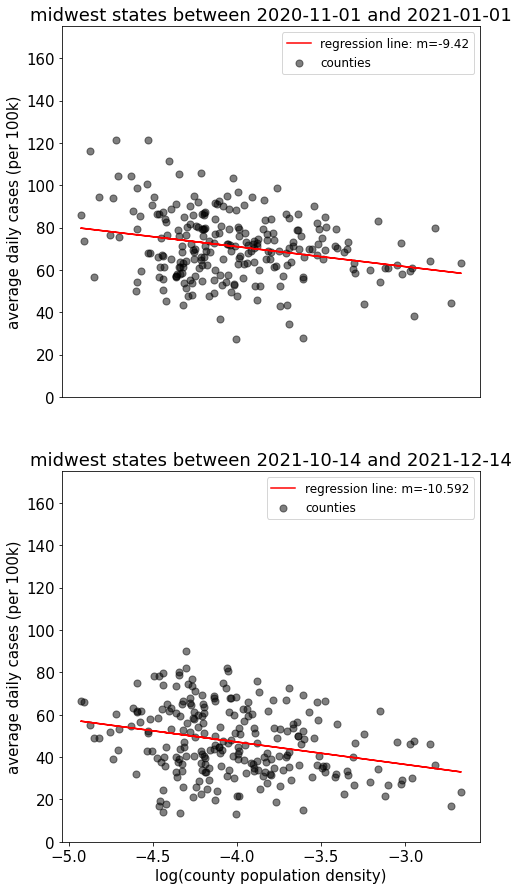

In [ ]:
start_date_1 = '2020-11-01'
end_date_1 = '2021-01-01'

start_date_2 = '2021-10-14'
end_date_2 = '2021-12-14'

xlims = [30,85]
ylims = [0,175]

fig = scatter_pop_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=midwest_states, state_list_name = 'midwest states', pop_density=True, y_column='new_cases', xlims=xlims, ylims=ylims)

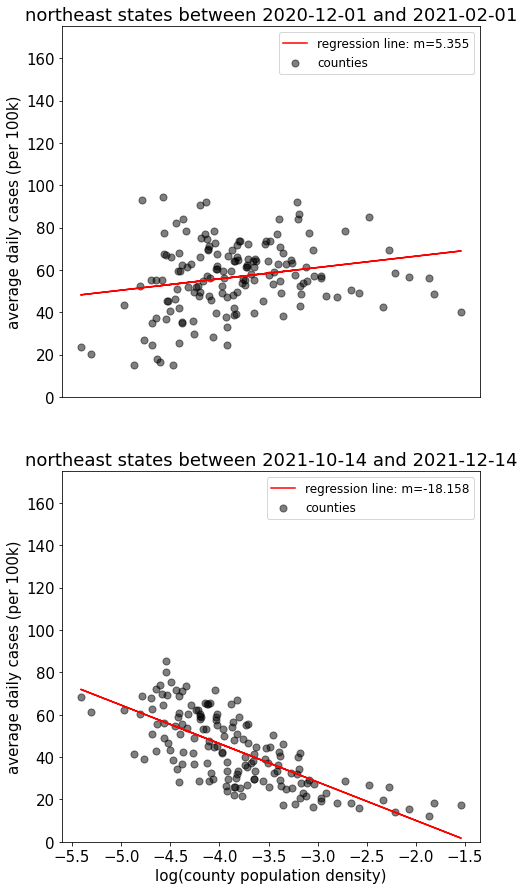

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-10-14'
end_date_2 = '2021-12-14'

xlims = [30,85]
ylims = [0,175]

fig = scatter_pop_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=northeast_states, state_list_name = 'northeast states', pop_density=True, y_column='new_cases', xlims=xlims, ylims=ylims)

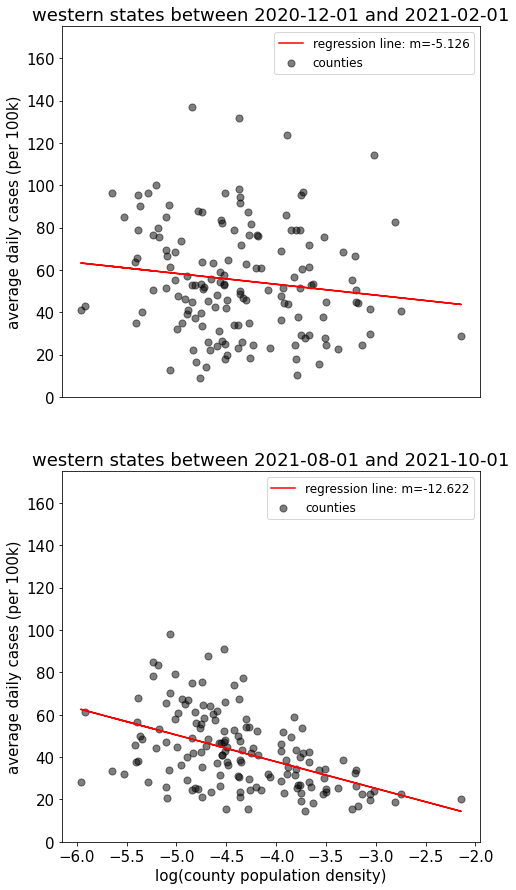

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-08-01'
end_date_2 = '2021-10-01'

xlims = [30,85]
ylims = [0,175]

fig = scatter_pop_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=western_states, state_list_name = 'western states', pop_density=True, y_column='new_cases', xlims=xlims, ylims=ylims)

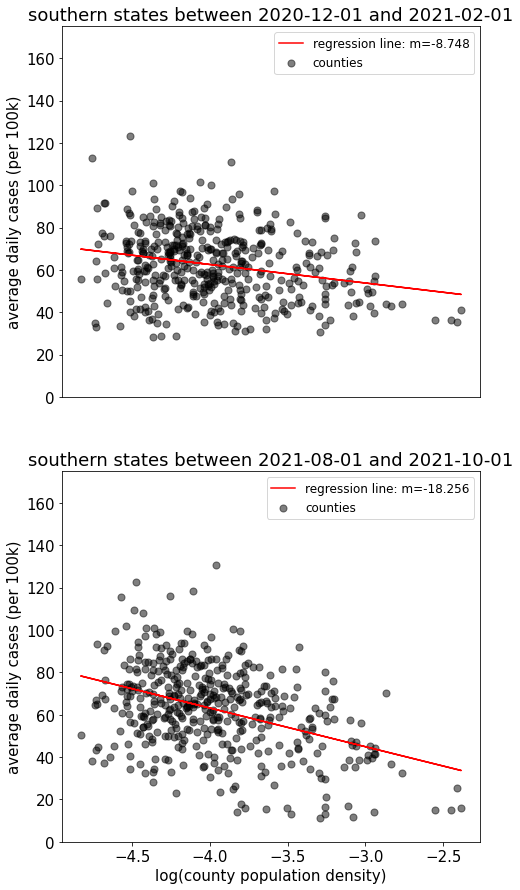

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-08-01'
end_date_2 = '2021-10-01'

xlims = [30,85]
ylims = [0,175]

fig = scatter_pop_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=southern_states, state_list_name = 'southern states', pop_density=True, y_column='new_cases', xlims=xlims, ylims=ylims)

In each of the four regions analyzed the slope of the regression line became more negative after people started to get vaccinated. The change in slope was smallest in the midwestern United States, with the slope changing from -9.4 pre-vaccine to -10.4 post-vaccine. In the northeastern United States the pre-vaccine slope was positive with a value of 5.4, and significantly decreased post-vaccine to -18.2. In the western United States the slope decreased from -5.1 pre-vaccine to -12.6 post-vaccine. In the southern United States the slope decreased from -8.7 pre-vaccine to -18.3 post-vaccine.
<br>
<br>
There are two trends that can be deduced from the results above:

- Population density is correlated with COVID-19 infection rates, as measured by the slope of a regression line
- Post-vaccine, the slope of the regression line is negative for all four regions and is decreased compared to pre-vaccine

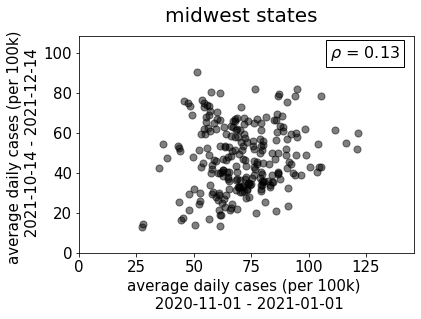

In [ ]:
start_date_1 = '2020-11-01'
end_date_1 = '2021-01-01'

start_date_2 = '2021-10-14'
end_date_2 = '2021-12-14'

xlims = [30,85]
ylims = [0,150]

scatter_date_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=midwest_states, state_list_name = 'midwest states', var='new_cases', pop_threshold=50000)

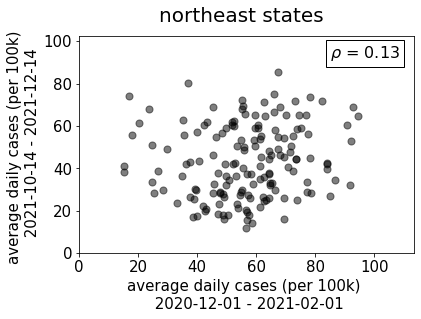

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-10-14'
end_date_2 = '2021-12-14'

xlims = [30,85]
ylims = [0,150]

scatter_date_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=northeast_states, state_list_name = 'northeast states', var='new_cases', pop_threshold=50000)

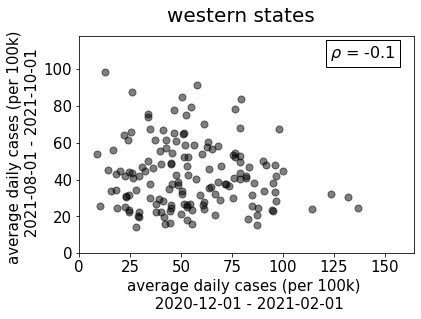

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-08-01'
end_date_2 = '2021-10-01'

xlims = [30,85]
ylims = [0,150]

scatter_date_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=western_states, state_list_name = 'western states', var='new_cases', pop_threshold=50000)

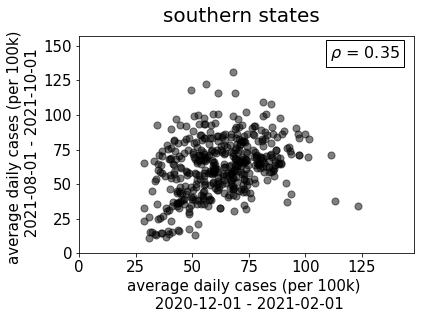

In [ ]:
start_date_1 = '2020-12-01'
end_date_1 = '2021-02-01'

start_date_2 = '2021-08-01'
end_date_2 = '2021-10-01'

xlims = [30,85]
ylims = [0,150]

scatter_date_comparison(covid_df, timestamps, start_date_1, end_date_1, start_date_2, end_date_2, state_list=southern_states, state_list_name = 'southern states', var='new_cases', pop_threshold=50000)

Each region showed either no correlation or a positive correlation between COVID-19 infections during the pre- and post-vaccine time periods specified. In other words, if COVID-19 infections were high in a particular county during the wave that occured late 2020 - early 2021, the infection rate was not on average lower (compared to the mean infection rate in that region) during the wave that occured mid-to-late 2021. In the case of the southern United States a high infection rate during the wave that occured late 2020 - early 2021 is associated with another high infection rate during the wave that occured mid-to-late 2021. These results are contrary to what would be expected if significant immunity was acquired in counties with high infection rates during the wave that occured late 2020 - early 2021.